In this notebook, corresponding to sections 1 and 2 in our report, we implement and optimize Gaussian mixture models (GMM) as a density estimator (i.e. in an unsupervised context) and classifier (supervised) on the two-moons dataset. At the end, we also use our supervised GMM as a generative model of the two-moons dataset, that is, we generate new samples from our GMM which resemble the original data. More detailed descriptions of the involved procedures, and analysis/interpretation of the results, can be found in the attached write-up.

# Part 1: GMM as density estimator.

In this part we use Gaussian mixture model as a density estimator algorithm, i.e. to estimate the PDF of some given data. The dataset we will train and test on is the sklearn two-moons dataset, which consists of an array of two-dimensional features representing two generated curves, or moons. We generate $n$ samples with a Gaussian noise added of $\sigma$.

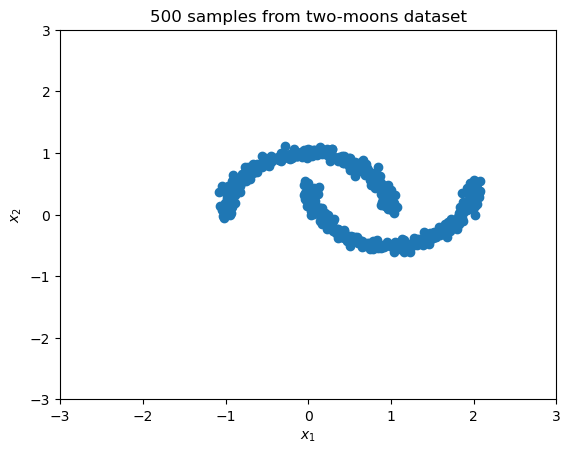

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm # for coloring level sets
import pandas as pd
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix

# import moons dataset, adjust its parameters
n = 500
sigma = .05
moons = make_moons(n_samples=n, noise=sigma, random_state=42) 
# setting random_state to 42 assigns a seed, letting anyone reproduce the exact data i use.
# noise corresponds to standard deviation of Gaussian noise added to dataset
# make_moons returns:
#    X : ndarray of shape (n_samples, 2)
#        The generated samples.
#    y : ndarray of shape (n_samples,)
#        The integer labels (0 or 1) for class membership of each sample.
moonsGeneratedSamples=moons[0]
moonsClassMembershipLabels=moons[1]
moonsX1=[]
moonsX2=[]
for k in range(0,len(moonsGeneratedSamples)):
    moonsX1.append(moonsGeneratedSamples[k][0])
    moonsX2.append(moonsGeneratedSamples[k][1])

# plotting the moons dataset
plt.scatter(moonsX1, moonsX2, marker='o')
plt.title('500 samples from two-moons dataset')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

We perform scikit-learn Gaussian mixture on the dataset. We then graph both the data and the level sets of the two Gaussian components in the model.

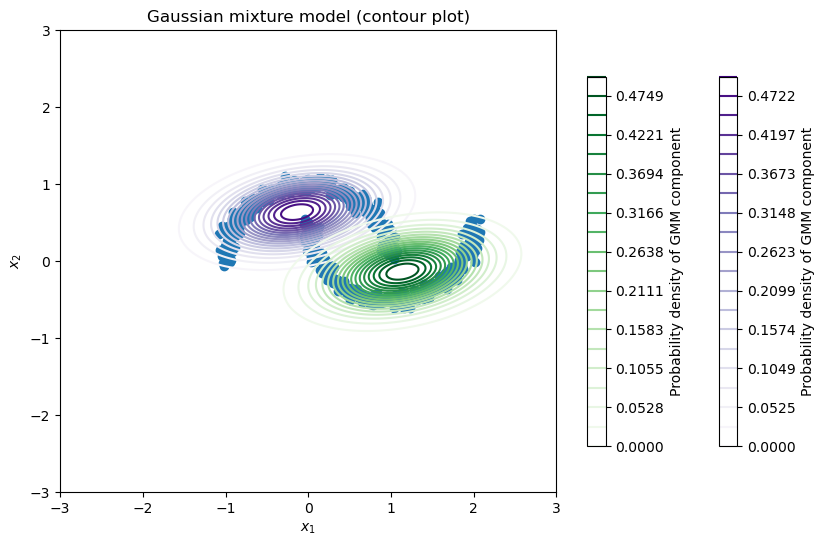

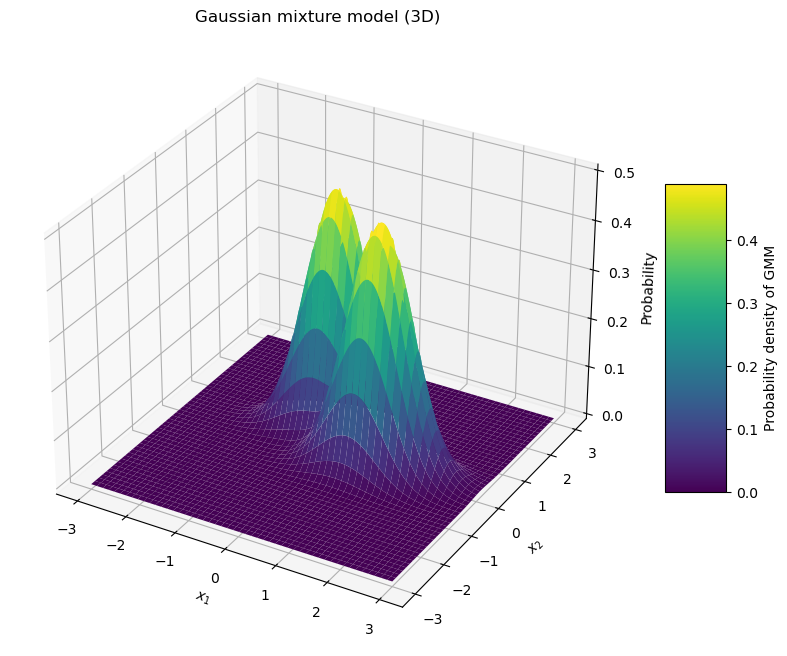

In [2]:
# generate grid points for evaluation
x = np.linspace(-3., 3., 300)
y = np.linspace(-3., 3., 300)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

# fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=2).fit(moonsGeneratedSamples)

# define colormaps for each component
cmaps = ['Purples', 'Greens']

# contour plot
plt.figure(figsize=(10, 6))
Z_total=np.zeros_like(X);
# plot the contours for each Gaussian component with different colormaps
for i in range(len(gmm.weights_)):
    # compute the Gaussian function for the current component
    mean = gmm.means_[i]
    cov = gmm.covariances_[i]
    weight = gmm.weights_[i]
    pdf = weight * np.exp(-0.5 * np.sum((XX - mean) @ np.linalg.inv(cov) * (XX - mean), axis=1))
    Z = pdf.reshape(X.shape)
    Z_total += pdf.reshape(X.shape)
    
    # choose colormap for the current component
    cmap = cmaps[i]
    
    # determine contour levels based on the probability distribution computed above (Z)
    levels = np.linspace(np.min(Z), np.max(Z), 20)
    
    # plot the contours
    CS = plt.contour(X, Y, Z, cmap=cmap, levels=levels)
    plt.colorbar(CS, shrink=0.8, extend='both', label='Probability density of GMM component')
    plt.title('Gaussian mixture model (contour plot)')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    
# plot the original dataset 
plt.scatter(moonsX1, moonsX2, marker='o')


# 3D plot:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# plot the surface
surf = ax.plot_surface(X, Y, Z_total, cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5, label='Probability density of GMM')

ax.set_title('Gaussian mixture model (3D)')
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel('Probability')

plt.show()

It's not a complete miss, but as we can see, the two Gaussians do not really capture the two shapes accurately. This is exactly as we would expect intuitively: looking at the two moons, we cannot really encode this geometric object accurately in two dimensions with two bells. However, if we increase the number of bells (i.e. Gaussians), we could place smaller bells roughly equidistant to each other along the curvature of each moon, and in doing so better capture the geometry of the two moons.

Increasing the number of components is obviously necessary, and we even witness an improvement after moving the number from 2 to 4, and then to 6. 

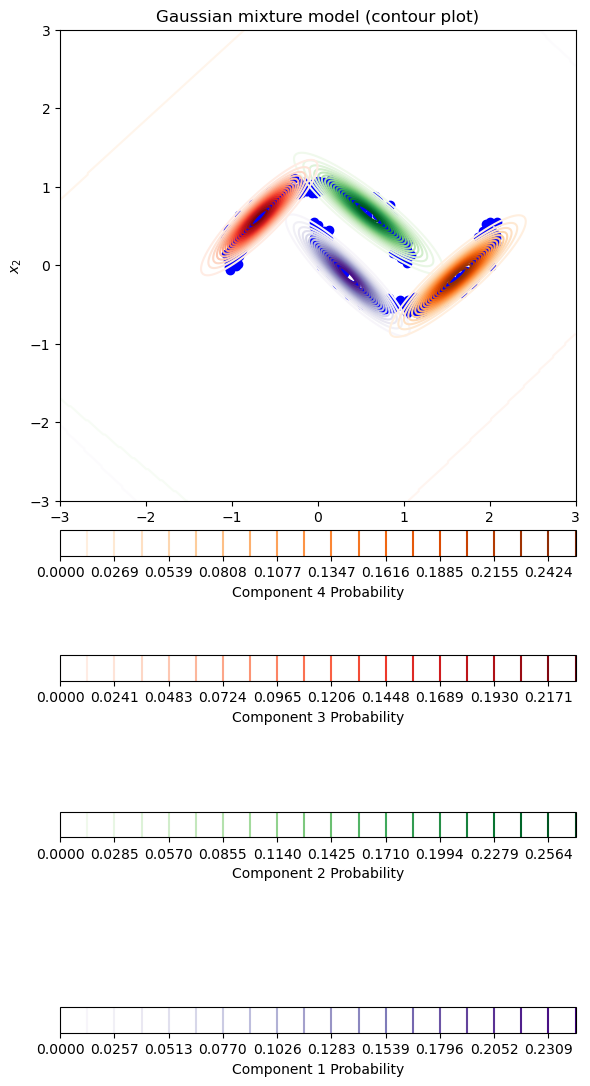

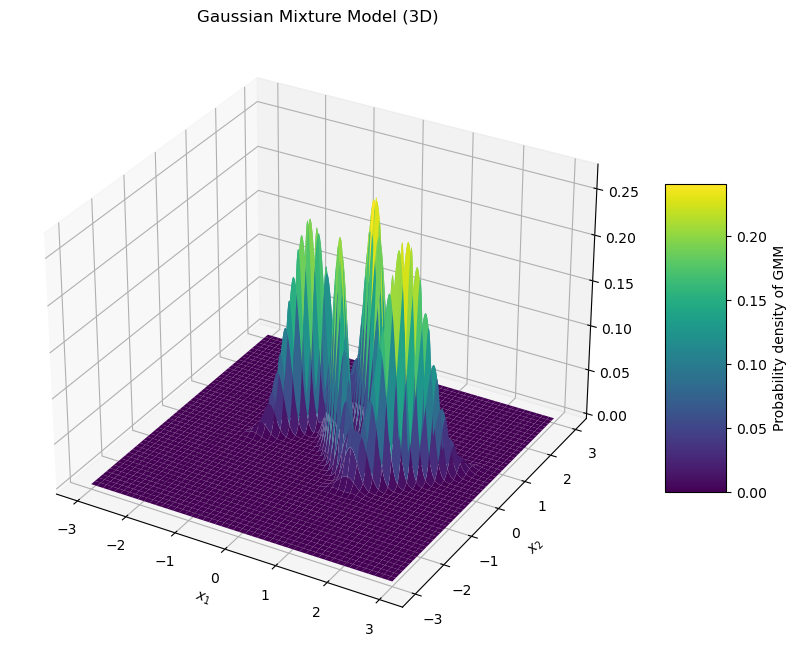

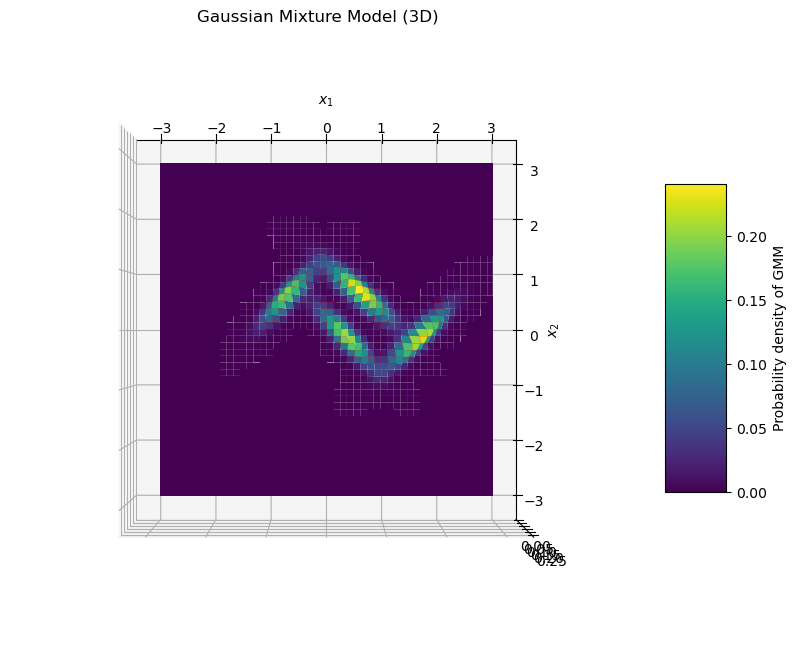

In [3]:
# fit Gaussian Mixture Model with 4 components
gmm = GaussianMixture(n_components=4).fit(moonsGeneratedSamples)

# define colormaps for each component
cmaps = ['Purples', 'Greens', 'Reds', 'Oranges']

# contour plot
fig, ax = plt.subplots(figsize=(6, 12)) 

Z_total = np.zeros_like(X) # this is going to "combine" the PDFs of all the components to plot in 3D

# plot the contours for each Gaussian component with different colormaps
for i in range(len(gmm.weights_)):  
    
    # compute the Gaussian function for the current component
    mean = gmm.means_[i]
    cov = gmm.covariances_[i]
    weight = gmm.weights_[i]
    pdf = weight * np.exp(-0.5 * np.sum((XX - mean) @ np.linalg.inv(cov) * (XX - mean), axis=1))
    Z = pdf.reshape(X.shape)
    Z_total += pdf.reshape(X.shape)
    
    # choose colormap for the current component
    cmap = cmaps[i]
    
    # determine contour levels based on the probability distribution computed above (Z)
    levels = np.linspace(np.min(Z), np.max(Z), 20)
    
    # plot contours
    CS = ax.contour(X, Y, Z, cmap=cmap, levels=levels)

    plt.title('Gaussian mixture model (contour plot)')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)

    # add color bar for the current component below the graph
    cbar = plt.colorbar(CS, ax=ax, orientation='horizontal', pad=0.05)  # Adjusted padding
    cbar.set_label(f'Component {i+1} Probability')

plt.tight_layout()

plt.scatter(moonsX1, moonsX2, marker='o', color='blue')

# 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# plot the surface
surf = ax.plot_surface(X, Y, Z_total, cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5, label='Probability density of GMM')
ax.set_title('Gaussian Mixture Model (3D)')
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

# 3D plot seen from above
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_total, cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5, label='Probability density of GMM')
ax.scatter(moonsX1, moonsX2, np.zeros_like(moonsX1), c='r', marker='o')
ax.set_title('Gaussian Mixture Model (3D)')
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.view_init(elev=90, azim=270)
plt.show()


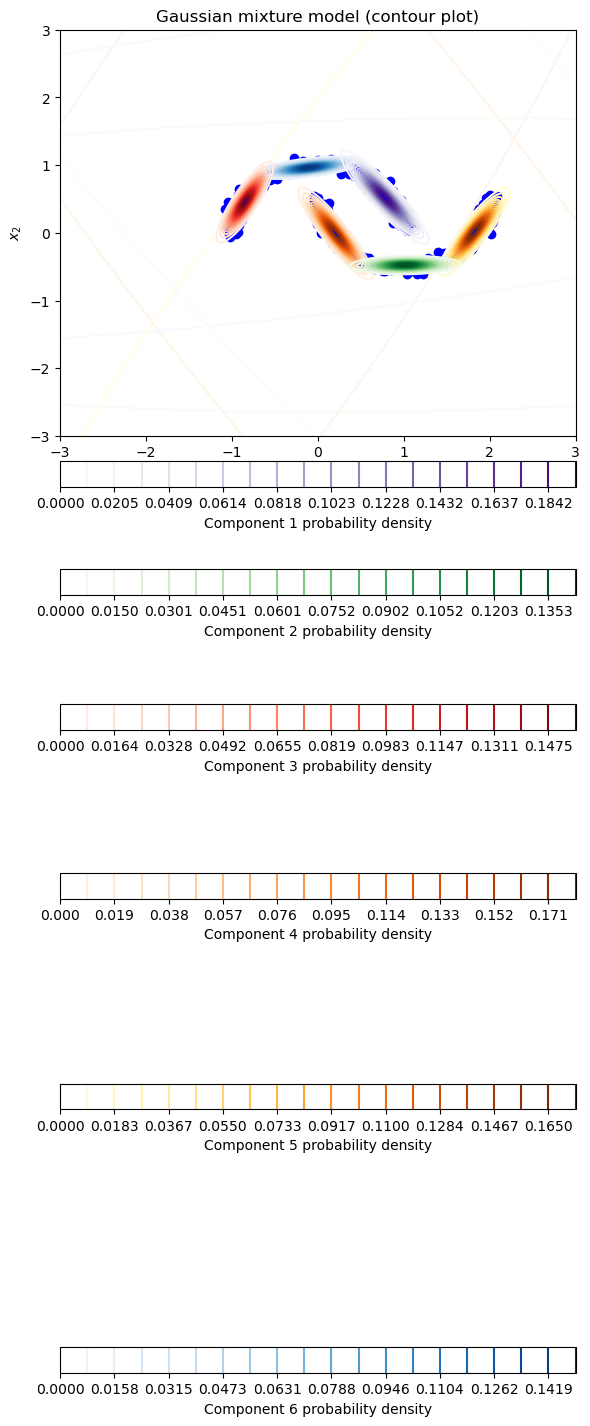

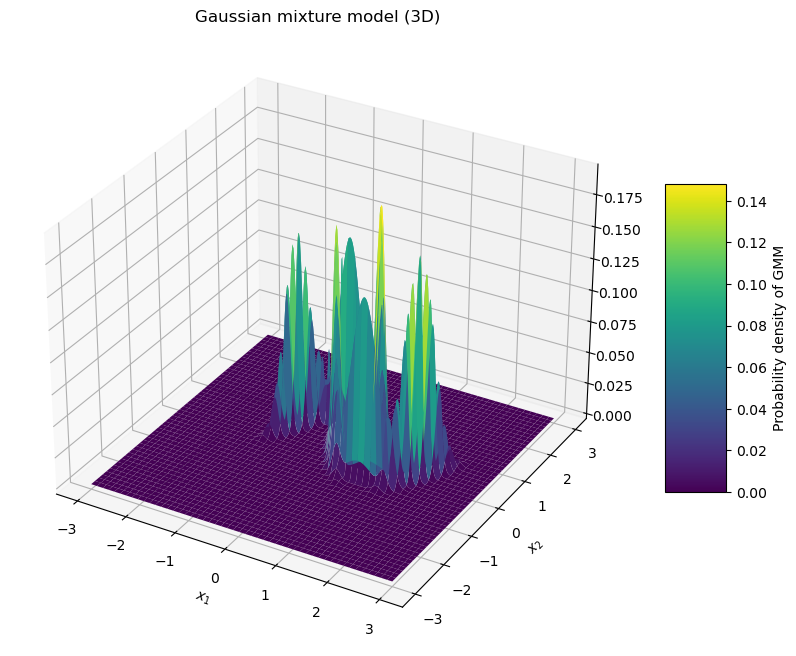

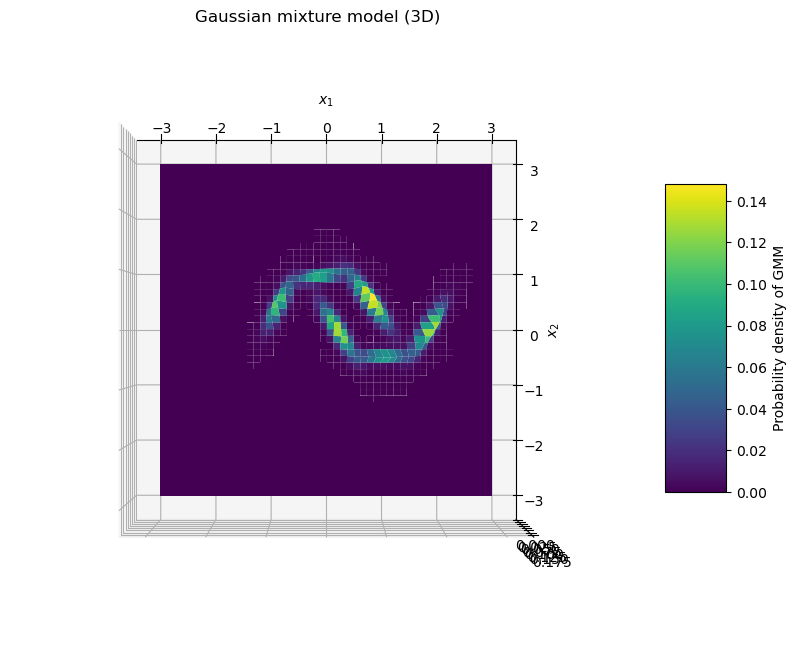

In [4]:
# fit Gaussian Mixture Model with 6 components
gmm = GaussianMixture(n_components=6).fit(moonsGeneratedSamples)

cmaps = ['Purples', 'Greens', 'Reds', 'Oranges', 'YlOrBr', 'Blues']


fig, ax = plt.subplots(figsize=(6, 16)) 
Z_total = np.zeros_like(X)

# plot the contours for each Gaussian component with different colormaps
for i in reversed(range(len(gmm.weights_))):  # Reverse the order
    # compute the Gaussian function for the current component
    mean = gmm.means_[i]
    cov = gmm.covariances_[i]
    weight = gmm.weights_[i]
    pdf = weight * np.exp(-0.5 * np.sum((XX - mean) @ np.linalg.inv(cov) * (XX - mean), axis=1))
    Z = pdf.reshape(X.shape)
    Z_total += pdf.reshape(X.shape)
    
    # choose colormap for the current component
    cmap = cmaps[i]
    
    # determine contour levels based on the probability distribution computed above (Z)
    levels = np.linspace(np.min(Z), np.max(Z), 20)
    
    # plot contours
    CS = ax.contour(X, Y, Z, cmap=cmap, levels=levels)

    plt.title('Gaussian mixture model (contour plot)')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)

    # add color bar for the current component below the graph
    cbar = plt.colorbar(CS, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label(f'Component {i+1} probability density')

plt.tight_layout()

plt.scatter(moonsX1, moonsX2, marker='o', color='blue')

# 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# plot the surface
surf = ax.plot_surface(X, Y, Z_total, cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5, label='Probability density of GMM')
ax.set_title('Gaussian mixture model (3D)')
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

# 3D plot seen from above
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_total, cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5, label='Probability density of GMM')
ax.set_title('Gaussian mixture model (3D)')
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.view_init(elev=90, azim=270)
plt.show()


To determine the optimal number of Gaussian components for our GMM, we test various number of components (from 1 to 30) using the Bayesian Information Criterion.

Optimal number of components according to BIC score: 9
BIC score: 694.1588709145899


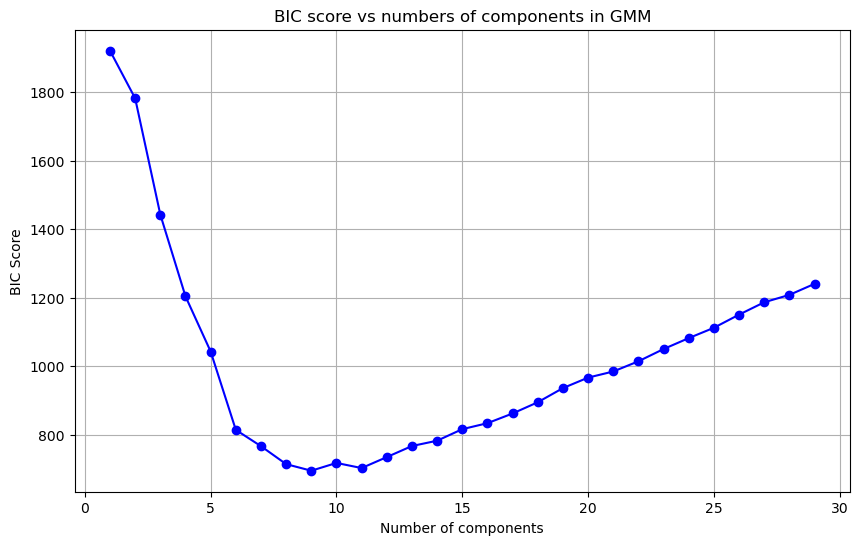

In [5]:
n_components_range = range(1, 30)
bic_scores = []

# for all k in {numbers of components we wish to test}
for n_components in n_components_range:
    # fit a k-component GMM to the dataset
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(moonsGeneratedSamples)
    # calculate its BIC; it gets n, k, and the likelihood function of the model from "gmm" (see report page 4)
    bic_scores.append(gmm.bic(moonsGeneratedSamples))

# store the results in a DataFrame
df = pd.DataFrame({
    'Number of Components': n_components_range,
    'BIC Score': bic_scores
})

# find/print the model with the lowest BIC score
optimal_model = df[df['BIC Score'] == df['BIC Score'].min()]
optimal_number_of_components = optimal_model['Number of Components'].values[0]

print("Optimal number of components according to BIC score:", optimal_model['Number of Components'].values[0])
print("BIC score:", optimal_model['BIC Score'].values[0])

# plot BIC scores
plt.figure(figsize=(10, 6))
plt.plot(df['Number of Components'], df['BIC Score'], marker='o', color='b', linestyle='-')
plt.title('BIC score vs numbers of components in GMM')
plt.xlabel('Number of components')
plt.ylabel('BIC Score')
plt.grid(True)
plt.show()

Using the BIC method we discover that $k$ (corresponding to optimal BIC) Gaussian components is optimal.
We try with $k$ components and see that we indeed obtain a much more accurate encoding of the two clusters of data.

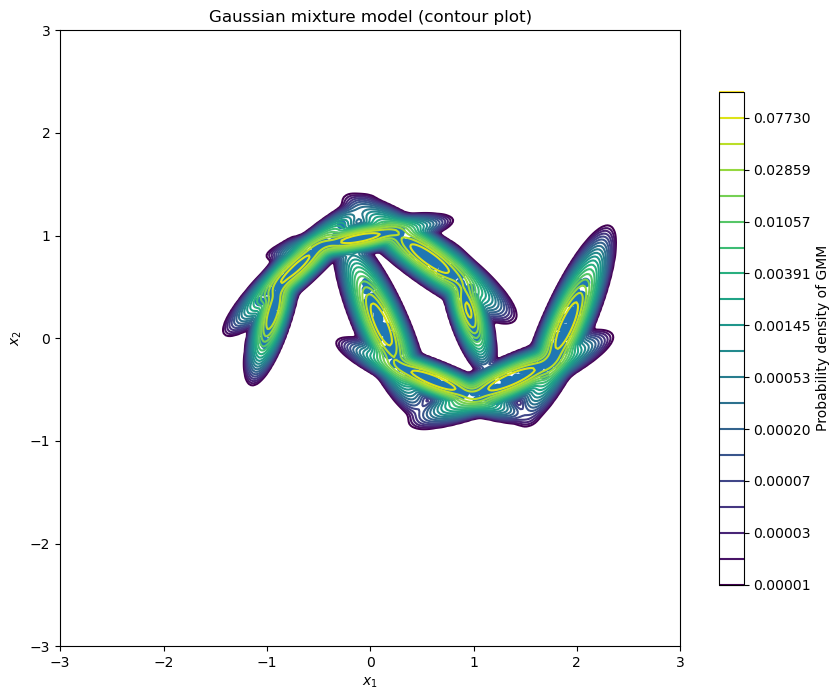

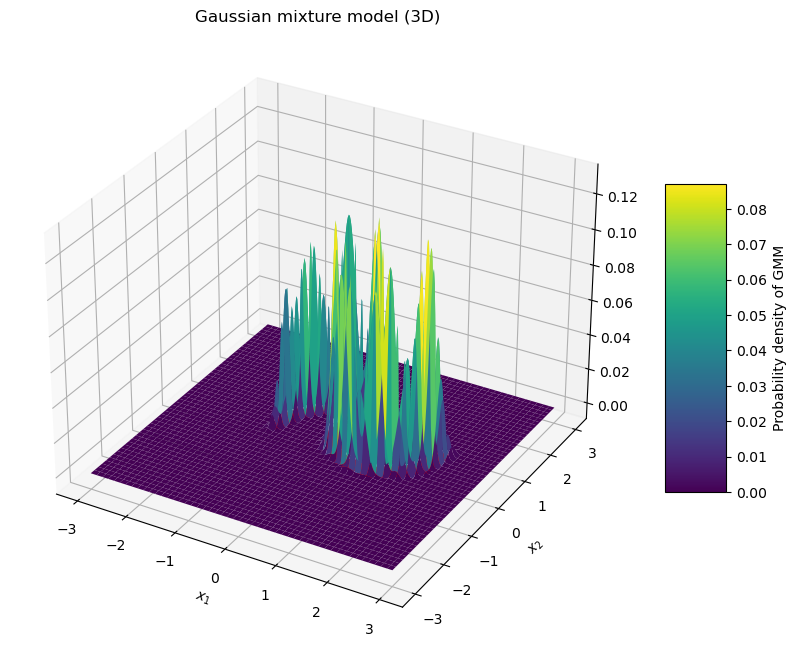

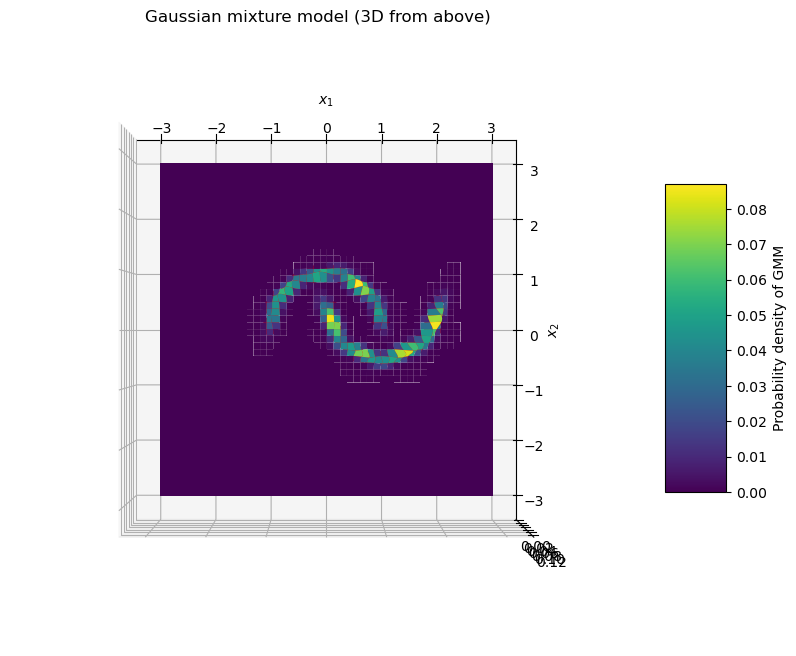

In [6]:
# fit Gaussian Mixture Model with optimal number of components
gmm = GaussianMixture(n_components=optimal_number_of_components).fit(moonsGeneratedSamples)

# compute the combined Gaussian functions for each component
Z_total = np.zeros_like(X)
for i in range(len(gmm.weights_)):
    mean = gmm.means_[i]
    cov = gmm.covariances_[i]
    weight = gmm.weights_[i]
    pdf = weight * np.exp(-0.5 * np.sum((XX - mean) @ np.linalg.inv(cov) * (XX - mean), axis=1))
    Z_total += pdf.reshape(X.shape)
    
# add a small epsilon to avoid log(0) while graphing level sets in contour plot
epsilon = 1e-5
min_val = np.min(Z_total[Z_total > epsilon])
max_val = np.max(Z_total)
levels = np.logspace(np.log10(min_val), np.log10(max_val), 20)

# graph level sets and dataset
plt.figure(figsize=(10, 8))
CS = plt.contour(X, Y, Z_total, cmap='viridis', norm=LogNorm(vmin=min_val, vmax=max_val),
                 levels=levels)
plt.colorbar(CS, shrink=0.8, extend='both', label='Probability density of GMM')
plt.title('Gaussian mixture model (contour plot)')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.scatter(moonsX1, moonsX2, marker='o')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

# 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_total, cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5, label='Probability density of GMM')
ax.scatter(moonsX1, moonsX2, np.zeros_like(moonsX1), c='r', marker='o')
ax.set_title('Gaussian mixture model (3D)')
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.show()

# 3D plot seen from above
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_total, cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5, label='Probability density of GMM')
ax.scatter(moonsX1, moonsX2, np.zeros_like(moonsX1), c='r', marker='o')
ax.set_title('Gaussian mixture model (3D from above)')
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.view_init(elev=90, azim=270)
plt.show()

# Part 2: GMM as classifier. 

We will use the labels given in the two-moons dataset use our GMM as a classifier.

The two-moons dataset comes with a set of labels corresponding to which of the two moons the data point is part of. Below we graph the dataset. The axes correspond to the two dimensions of the features of the dataset, and the color corresponds to the label. Blue=class 0, red=class 1.

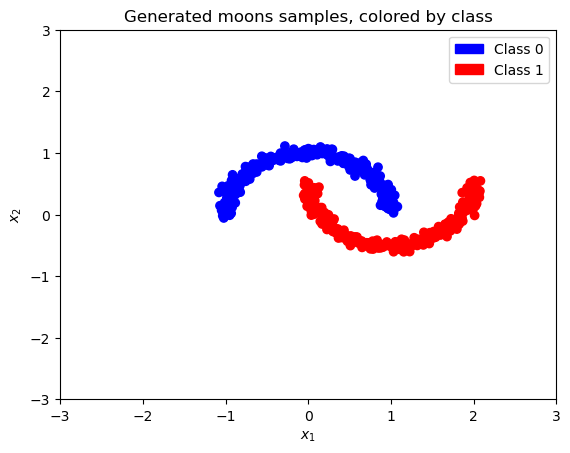

In [7]:
# plotting the moons dataset with colors based on class membership
colors = ['blue' if label == 0 else 'red' for label in moons[1]]
plt.scatter(moonsX1, moonsX2, c=colors, marker='o')
plt.title('Generated moons samples, colored by class')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
import matplotlib.patches as mpatches # adding a legend :)
class0 = mpatches.Patch(color='blue', label='Class 0')
class1 = mpatches.Patch(color='red', label='Class 1')
plt.legend(handles=[class0, class1])
plt.show()

Let's use GMM to try to classify these data points. We want to use expectation maximization (EM) to classify the data points in two-moons according to either 0 or 1. We will to use a train test split of 0.2 on the data. The labels included in Moons represent the correct class. Using expectation maximization, we will classify such that point $x_i=(x_1,x_2)$ belongs to the class $k=\text{argmax}_{l\in\{0,1\}} P(Y=l | X=x_i)$, where $P(Y=l | X=x_i)$ is the responsibility of component $l$ for data point $x_i$. Then we will graph the results and color based on the classification. Red is 1 and blue is 0.

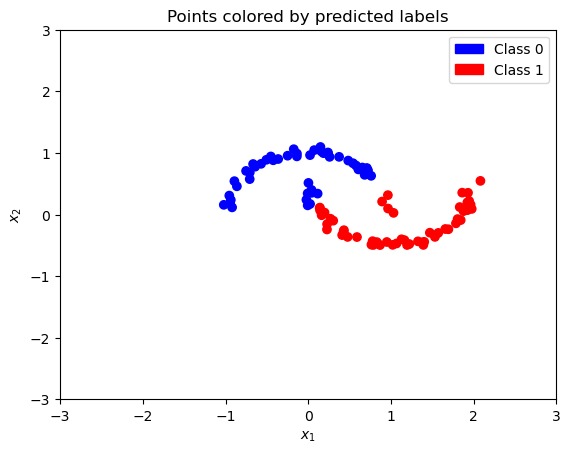

In [8]:
from sklearn.model_selection import train_test_split

X, y = moons

# split dataset into train and test sets with test size 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# most of the data should go to training so our model can learn well.

# fit a GMM with two components on the training set
gmm = GaussianMixture(n_components=2, random_state=42).fit(X_train)

# predict labels for test set using the trained model.
# according to sklearn source code on github, this returns a list of classes corresponding to k = arg max over l in (0,1) of the responsibility of l for x_i.
predicted_labels = gmm.predict(X_test)

# plot the points, colored according to the predicted labels
colors = ['blue' if label == 0 else 'red' for label in predicted_labels]
plt.scatter(X_test[:, 0], X_test[:, 1], c=colors, cmap='coolwarm', marker='o')
plt.title('Points colored by predicted labels')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
class0 = mpatches.Patch(color='blue', label='Class 0')
class1 = mpatches.Patch(color='red', label='Class 1')
plt.legend(handles=[class0, class1])
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()


We observe that using only 2 Gaussian components, we don't get a particularly accurate classification of the data. This classification is only negligibly improved by adjusting the train/test split ratio *graph if you need to fill space* nor by increasing the number of samples to e.g. n=1000. *again graph this if you need to fill space*.

To deal with having more components than classes, we implement a "majority rule", described in detail in the report.

Then, to decide how many components we should use, we use a simple "accuracy" metric, which works well for binary classification into classes of roughly equal size; we test accuracy vs. number of components using a cross-validation procedure known as Stratified $K$-Folds (using a different $K$ than our $k$-component GMM.) We then also compute the F1 score for different numbers of components. 

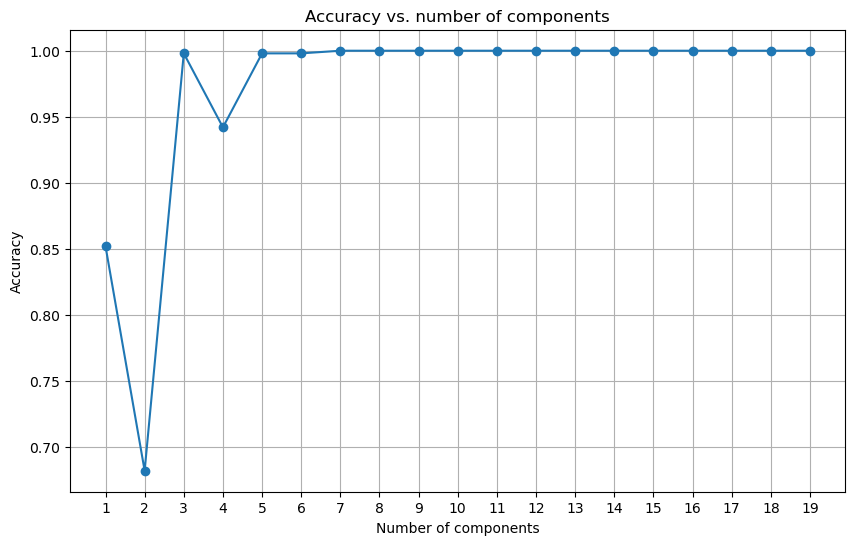

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

def optimal_gmm_components_accuracy_custom(X, y, max_components):

    best_accuracy = 0
    best_n = 0
    accuracy_scores_list = []
    
    # create stratified KFold object
    skf = StratifiedKFold(n_splits=5)
    
    # loop over possible number of components
    for n in range(2, max_components+1):
        accuracy_scores = []
        
        # perform cross-validation
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # fit GMM
            gmm = GaussianMixture(n_components=n, random_state=42)
            gmm.fit(X_train)
            
            # assign classes to components
            component_assignments = []
            for i in range(n):
                density_class_0 = np.sum(gmm.predict_proba(X_train[y_train == 0])[:, i])
                density_class_1 = np.sum(gmm.predict_proba(X_train[y_train == 1])[:, i])
                if density_class_0 > density_class_1:
                    component_assignments.append(0)
                else:
                    component_assignments.append(1)
            
            # predict labels
            y_pred = np.array([component_assignments[gmm.predict([point])[0]] for point in X_test])
            
            # calculate accuracy score and append to list
            accuracy = accuracy_score(y_test, y_pred)
            accuracy_scores.append(accuracy)
        
        # calculate mean accuracy score
        mean_accuracy = np.mean(accuracy_scores)
        accuracy_scores_list.append(mean_accuracy)
        
        # if this is the best accuracy score so far, update best_accuracy and best_n
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_n = n
    
    # plot the accuracy scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_components), accuracy_scores_list, marker='o')
    plt.xticks(range(1, max_components))  # Set xticks to every integer value
    plt.title('Accuracy vs. number of components')
    plt.xlabel('Number of components')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    return best_n

o = optimal_gmm_components_accuracy_custom(X, y, 20)

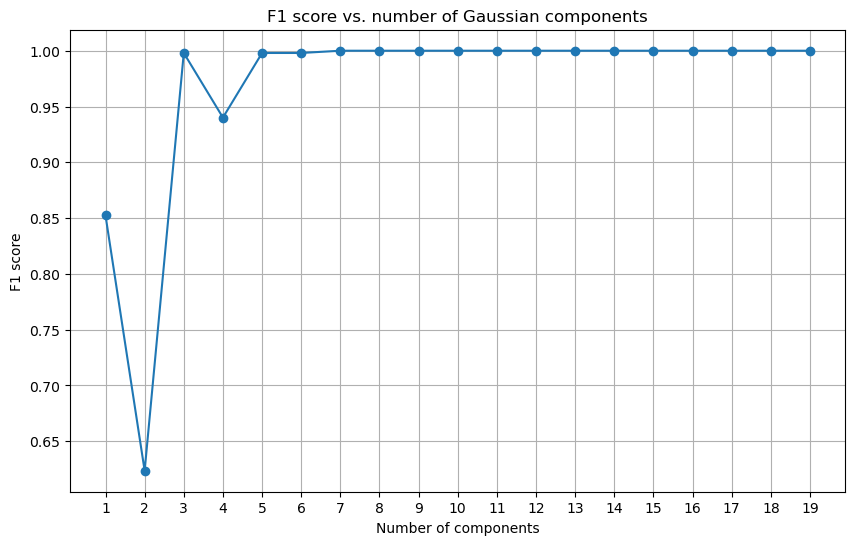

In [10]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

def optimal_gmm_components_f1_weighted(X, y, max_components=10):
    
    best_f1 = 0
    best_n = 0
    f1_scores_list = []
    
    # create stratified KFold object
    skf = StratifiedKFold(n_splits=5)
    
    # loop over possible numbers of components
    for n in range(2, max_components+1):
        f1_scores = []
        
        # perform cross-validation
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # fit GMM
            gmm = GaussianMixture(n_components=n, random_state=42)
            gmm.fit(X_train)
            
            # assign classes to components
            component_assignments = []
            for i in range(n):
                density_class_0 = np.sum(gmm.predict_proba(X_train[y_train == 0])[:, i])
                density_class_1 = np.sum(gmm.predict_proba(X_train[y_train == 1])[:, i])
                if density_class_0 > density_class_1:
                    component_assignments.append(0)
                else:
                    component_assignments.append(1)
            
            # predict labels
            y_pred = np.array([component_assignments[gmm.predict([point])[0]] for point in X_test])
            
            # calculate F1 score and append to list
            f1 = f1_score(y_test, y_pred, average='binary')
            f1_scores.append(f1)
        
        # calculate mean F1 score
        mean_f1 = np.mean(f1_scores)
        f1_scores_list.append(mean_f1)
        
        # if this is the best F1 score so far, update best_f1 and best_n
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_n = n      
    
    # plot the F1 scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_components), f1_scores_list, marker='o')
    plt.xticks(range(1, max_components))  # Set xticks to every integer value
    plt.title('F1 score vs. number of Gaussian components')
    plt.xlabel('Number of components')
    plt.ylabel('F1 score')
    plt.grid(True)
    plt.show()
    
    return best_n

o = optimal_gmm_components_f1_weighted(X, y, 20)

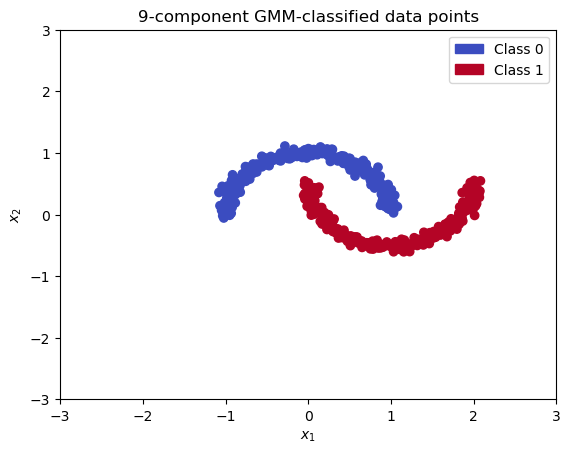

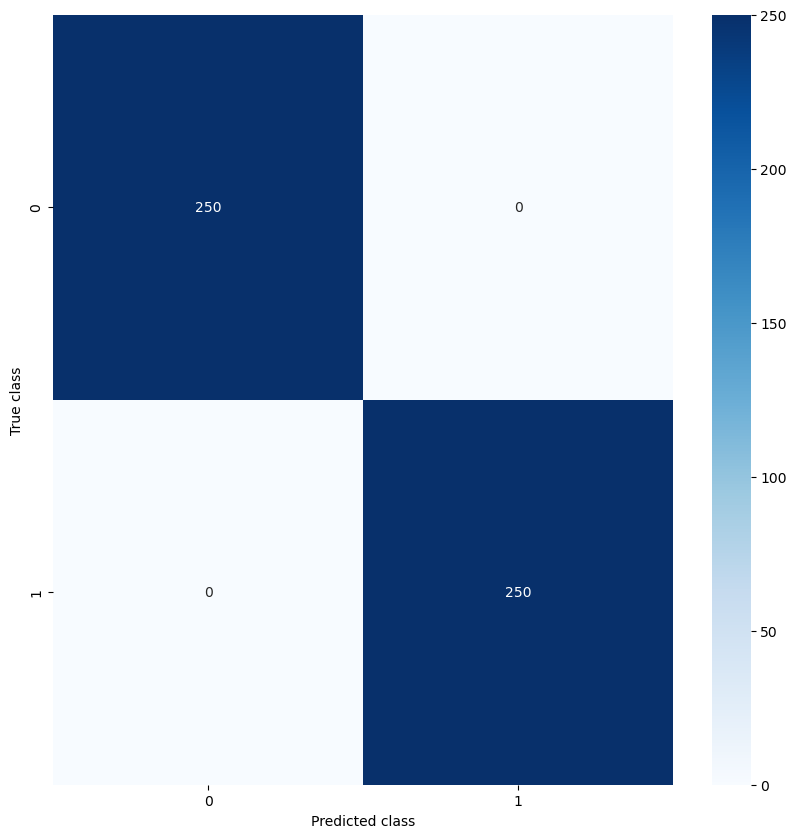

In [11]:
n_components=9 # change num components for GMM classifier here

gmm = GaussianMixture(n_components=n_components, random_state=42).fit(X)

# evaluate each component of the GMM at the points of each class separately
component_assignments = [] # array to store the assigned class for each component

# for each component of the GMM,
for i in range(n_components):
    
    # compute the sum of the probability densities that all points with class k in {0,1} are lying in the Gaussian of that component.
    density_class_0 = np.sum(gmm.predict_proba(X[y == 0])[:, i])
    density_class_1 = np.sum(gmm.predict_proba(X[y == 1])[:, i])
    
    # then, assign the component to the class with the majority of points within its standard deviation
    if density_class_0 > density_class_1:
        component_assignments.append(0)
    else:
        component_assignments.append(1)

# classify each data point based on the component it belongs to
classified_labels = np.array([component_assignments[gmm.predict([point])[0]] for point in X])

# plot the data points colored by their predicted classes
plt.scatter(X[:, 0], X[:, 1], c=classified_labels, cmap='coolwarm', marker='o')
plt.title(str(n_components)+'-component GMM-classified data points')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
class0 = mpatches.Patch(color='#3b4cc0', label='Class 0')
class1 = mpatches.Patch(color='#b40426', label='Class 1')
plt.legend(handles=[class0, class1])
plt.show()



# compute the confusion matrix
cm = confusion_matrix(classified_labels, y)

# plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()


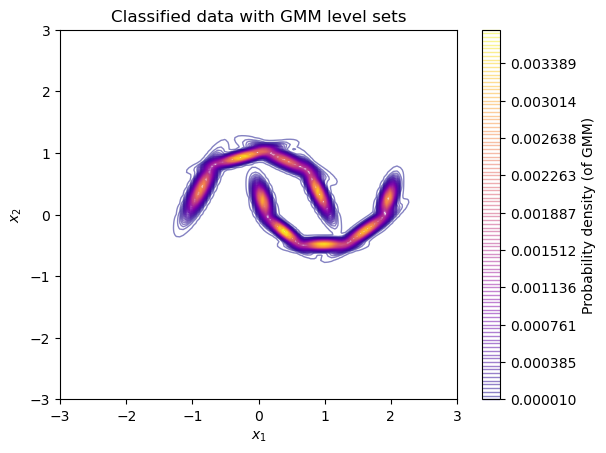

In [12]:
# plot the level sets of the GMM components with actual probability densities
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = gmm.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = np.exp(Z) / np.sum(np.exp(Z))  # normalize to ensure probabilities sum up to 1
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=np.linspace(Z.min()+1e-5, Z.max(), 100), linewidths=1, alpha=0.5, cmap='plasma')
plt.title('Classified data with GMM level sets')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-3, 3)  
plt.ylim(-3, 3) 
plt.colorbar(label='Probability density (of GMM)')
plt.show()



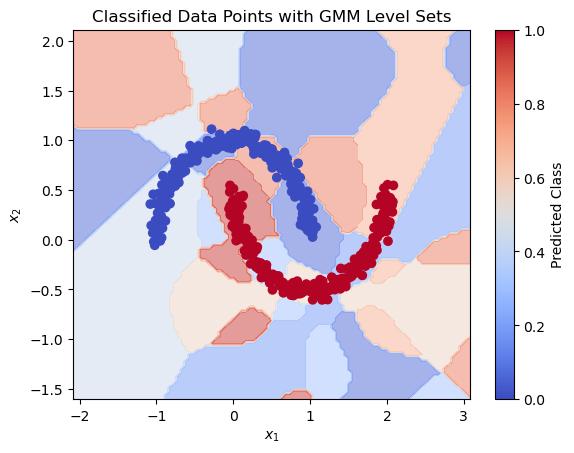

In [13]:
# evaluate the probabilities for each class at each point on the meshgrid
probs = gmm.predict_proba(np.c_[xx.ravel(), yy.ravel()])
probs = probs.reshape(xx.shape + (n_components,))

# determine the predicted class for each point based on the highest probability
predicted_classes = np.argmax(probs, axis=-1)

# plot the contour plots with probabilities for each class
plt.contourf(xx, yy, predicted_classes, cmap='coolwarm', alpha=0.5)

# plot the data points colored by their predicted classes
plt.scatter(X[:, 0], X[:, 1], c=classified_labels, cmap='coolwarm', marker='o')

plt.title('Classified Data Points with GMM Level Sets')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.colorbar(label='Predicted Class')
plt.show()


Now that we have the optimal number of components in our Gaussian mixture model, we can generate points from it. The reason is that it is relatively simple to generate points from a Gaussian distribution and therefore from a GMM. We will generate 500 points from our GMM, and observe that they approximately reproduce the two moons. 

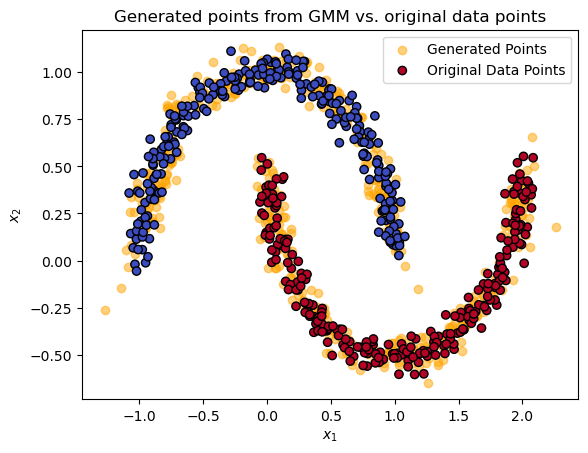

In [14]:
# generate 500 points from the GMM
generated_points, _ = gmm.sample(500)

# plot the generated points
plt.scatter(generated_points[:, 0], generated_points[:, 1], marker='o', color='orange', alpha=0.5, label='Generated Points')

# plot the original data points (two moons)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', marker='o', edgecolors='black', label='Original Data Points')

plt.title('Generated points from GMM vs. original data points')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.show()